# MuRIL Domain Adversarial Training (DAT) for Telugu text Suicide Detection using English as a pivot.

This script trains a `google/muril-base-cased` model for binary text classification (suicide vs. non-suicide detection) on combined English and Telugu datasets. It employs Domain Adversarial Training (DAT) to improve the model's ability to generalize across languages (domains).

**Core Components and Workflow:**

1.  **Setup:**
    * Imports necessary libraries (`torch`, `transformers`, `pandas`, `sklearn`, etc.).
    * Sets a random seed (`42`) for reproducibility.
    * Detects available device (GPU/CPU) and enables multi-GPU training using `nn.DataParallel` if available.
    * Enables cuDNN benchmarking for potential performance optimization.

2.  **Data Loading and Preparation:**
    * Loads English and Telugu datasets from specified CSV files.
    * Assigns domain labels: `0` for English, `1` for Telugu.
    * Concatenates the two datasets into a single dataframe (`full_df`).
    * Splits the combined data into training (`train_df`) and validation (`val_df`) sets (80/20 split) using `train_test_split`, ensuring stratification by both class label and domain label.

3.  **Custom Classes for DAT:**
    * **`SuicideDataset`:** A standard PyTorch `Dataset` class to handle tokenization (using the MuRIL tokenizer) and retrieval of text, class labels, and domain labels.
    * **`BalancedBatchSampler`:** A custom PyTorch `Sampler` used *only for the training DataLoader*. It ensures each training batch contains an equal number of samples from the English domain (0) and the Telugu domain (1). This is crucial for stable DAT.
    * **`GradientReversal` Layer:** Implements the Gradient Reversal Layer (GRL) as a custom `torch.autograd.Function`. During the forward pass, it acts as an identity function. During the backward pass, it multiplies the incoming gradient by `-lambda_`, effectively reversing the gradient flow from the domain classifier back into the feature extractor.
    * **`DATModel`:** Defines the model architecture:
        * Uses `google/muril-base-cased` as the base feature extractor.
        * Takes the CLS token's output (`last_hidden_state[:, 0, :]`) as the feature representation.
        * Applies dropout.
        * Has a `task_classifier` head (predicts the class label: suicide/non-suicide).
        * Has a `domain_classifier` head (predicts the domain: English/Telugu).
        * **Crucially, applies the `GradientReversal` layer to the features *before* feeding them to the `domain_classifier`.**

4.  **Initialization:**
    * Loads the MuRIL tokenizer and base model.
    * Instantiates the `DATModel`.
    * Moves the model to the appropriate device.
    * Wraps the model with `nn.DataParallel` if multiple GPUs are detected.

5.  **Training Setup:**
    * Creates `Dataset` instances for train and validation sets.
    * Creates the `train_loader` using the `BalancedBatchSampler` to get domain-balanced batches.
    * Creates the `val_loader` using a standard sequential sampler.
    * Defines loss functions: `nn.CrossEntropyLoss` for both the task and domain classification heads.
    * Sets up the `AdamW` optimizer.
    * Initializes `GradScaler` for Automatic Mixed Precision (AMP) training, which can speed up training and reduce memory usage on compatible GPUs.

6.  **Training Loop (`num_epochs = 3`):**
    * For each epoch:
        * Sets the model to `train()` mode.
        * Iterates through batches provided by the `train_loader` (balanced domains).
        * Performs a forward pass through the `DATModel` using `autocast` for AMP. This yields `task_logits` and `domain_logits`.
        * Calculates `task_loss` (how well the model predicts the class).
        * Calculates `domain_loss` (how well the model predicts the domain *after* GRL).
        * **Combines losses:** `total_loss = task_loss + lambda_ * domain_loss`. The `lambda_` parameter (set to 1.0) weights the contribution

In [4]:
#!/usr/bin/env python3
# chatGPT

import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Sampler
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
import os
import random
from itertools import cycle
import time
from torch.cuda.amp import autocast, GradScaler

# Set random seed
torch.manual_seed(42)
torch.backends.cudnn.benchmark = True  # Optimize GPU performance

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")

# Load datasets
english_df = pd.read_csv("/kaggle/input/english-ds-binary/BinaryCsv_English_dataset_UTF8.csv", encoding='utf-8')
telugu_df = pd.read_csv("/kaggle/input/telugu-ds-binary/Binary_telugu_dataset.csv", encoding='utf-8')

# Add domain labels
english_df['domain'] = 0
telugu_df['domain'] = 1

# Combine datasets
full_df = pd.concat([english_df, telugu_df])

# Split into train and validation sets
train_df, val_df = train_test_split(full_df, test_size=0.2, stratify=full_df[['class', 'domain']])

# Custom Dataset class
class SuicideDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['class'].tolist()
        self.domains = dataframe['domain'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        domain = self.domains[idx]
        encoding = self.tokenizer(
            text, return_tensors='pt', max_length=self.max_length,
            truncation=True, padding='max_length'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long),
            'domains': torch.tensor(domain, dtype=torch.long)
        }

# Balanced Batch Sampler
class BalancedBatchSampler(Sampler):
    def __init__(self, dataset, batch_size_per_lang):
        self.eng_indices = [i for i, domain in enumerate(dataset.domains) if domain == 0]
        self.tel_indices = [i for i, domain in enumerate(dataset.domains) if domain == 1]
        self.batch_size_per_lang = batch_size_per_lang
        self.total_batches = len(self.eng_indices) // batch_size_per_lang

    def __iter__(self):
        random.shuffle(self.eng_indices)
        tel_iter = cycle(self.tel_indices)
        for i in range(self.total_batches):
            eng_batch = self.eng_indices[i * self.batch_size_per_lang:(i + 1) * self.batch_size_per_lang]
            tel_batch = [next(tel_iter) for _ in range(self.batch_size_per_lang)]
            yield eng_batch + tel_batch

    def __len__(self):
        return self.total_batches

# Gradient Reversal Layer
class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

# DAT Model
class DATModel(nn.Module):
    def __init__(self, base_model, hidden_size=768, num_classes=2, num_domains=2):
        super(DATModel, self).__init__()
        self.base_model = base_model
        self.task_classifier = nn.Linear(hidden_size, num_classes)
        self.domain_classifier = nn.Linear(hidden_size, num_domains)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask, lambda_=1.0):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        features = outputs.last_hidden_state[:, 0, :]
        features = self.dropout(features)
        task_logits = self.task_classifier(features)
        domain_features = GradientReversal.apply(features, lambda_)
        domain_logits = self.domain_classifier(domain_features)
        return task_logits, domain_logits

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
base_model = AutoModel.from_pretrained("google/muril-base-cased")
model = DATModel(base_model).to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# Create datasets
train_dataset = SuicideDataset(train_df, tokenizer)
val_dataset = SuicideDataset(val_df, tokenizer)

# DataLoader settings
batch_size_per_lang = 64  # 32 English + 32 Telugu = 64 total batch size
train_sampler = BalancedBatchSampler(train_dataset, batch_size_per_lang)
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Loss functions
criterion_task = nn.CrossEntropyLoss()
criterion_domain = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# AMP (Mixed Precision Training)
scaler = GradScaler()


Using device: cuda
Using 2 GPUs


<ipython-input-4-3315443d99ff>:142: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


**# Training loop**

In [1]:


num_epochs = 3
lambda_ = 1.0

for epoch in range(num_epochs):
    model.train()
    total_batches = len(train_loader)
    
    # Initialize epoch metrics
    total_task_loss = 0.0
    total_domain_loss = 0.0
    total_correct_task = 0
    total_samples = 0
    start_time = time.time()
    
    for batch_idx, batch in enumerate(train_loader, 1):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        domains = batch['domains'].to(device)

        optimizer.zero_grad()

        with autocast():
            task_logits, domain_logits = model(input_ids, attention_mask, lambda_)
            task_loss = criterion_task(task_logits, labels)
            domain_loss = criterion_domain(domain_logits, domains)
            total_loss = task_loss + lambda_ * domain_loss

        # Scale loss and backpropagate
        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update epoch metrics
        total_task_loss += task_loss.item()
        total_domain_loss += domain_loss.item()
        predictions = torch.argmax(task_logits, dim=1)
        total_correct_task += torch.sum(predictions == labels).item()
        total_samples += labels.size(0)

        # Print metrics every 100 batches
        if batch_idx % 100 == 0:
            progress = (batch_idx / total_batches) * 100
            print(f"Epoch {epoch+1}, Batch {batch_idx}/{total_batches} ({progress:.2f}%), "
                  f"Task Loss: {task_loss.item():.4f}, Domain Loss: {domain_loss.item():.4f}, "
                  f"Task Accuracy: {(predictions == labels).float().mean():.4f}")

    # Epoch summary metrics
    epoch_task_loss = total_task_loss / len(train_loader)
    epoch_domain_loss = total_domain_loss / len(train_loader)
    epoch_task_accuracy = total_correct_task / total_samples
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1} Completed: Task Loss: {epoch_task_loss:.4f}, "
          f"Domain Loss: {epoch_domain_loss:.4f}, Task Accuracy: {epoch_task_accuracy:.4f}, "
          f"Time: {epoch_time:.2f}s")

    # Overall Validation metrics calculation (on entire 20% split)
    model.eval()
    val_task_loss = 0.0
    val_domain_loss = 0.0
    val_correct = 0
    val_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            domains = batch['domains'].to(device)
            
            with autocast():
                task_logits, domain_logits = model(input_ids, attention_mask, lambda_)
                loss_task = criterion_task(task_logits, labels)
                loss_domain = criterion_domain(domain_logits, domains)
            
            val_task_loss += loss_task.item()
            val_domain_loss += loss_domain.item()
            predictions = torch.argmax(task_logits, dim=1)
            val_correct += torch.sum(predictions == labels).item()
            val_samples += labels.size(0)
    
    val_task_loss /= len(val_loader)
    val_domain_loss /= len(val_loader)
    val_accuracy = val_correct / val_samples
    print(f"Validation (Overall) - Task Loss: {val_task_loss:.4f}, Domain Loss: {val_domain_loss:.4f}, "
          f"Task Accuracy: {val_accuracy:.4f}")

    # Telugu-specific Validation metrics calculation
    # Filter the validation DataFrame for Telugu samples (domain==1)
    telugu_val_df = val_df[val_df['domain'] == 1]
    telugu_val_dataset = SuicideDataset(telugu_val_df, tokenizer)
    telugu_val_loader = DataLoader(telugu_val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
    
    telugu_val_task_loss = 0.0
    telugu_val_domain_loss = 0.0
    telugu_val_correct = 0
    telugu_val_samples = 0
    with torch.no_grad():
        for batch in telugu_val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            domains = batch['domains'].to(device)
            
            with autocast():
                task_logits, domain_logits = model(input_ids, attention_mask, lambda_)
                loss_task = criterion_task(task_logits, labels)
                loss_domain = criterion_domain(domain_logits, domains)
            
            telugu_val_task_loss += loss_task.item()
            telugu_val_domain_loss += loss_domain.item()
            predictions = torch.argmax(task_logits, dim=1)
            telugu_val_correct += torch.sum(predictions == labels).item()
            telugu_val_samples += labels.size(0)
    
    telugu_val_task_loss /= len(telugu_val_loader)
    telugu_val_domain_loss /= len(telugu_val_loader)
    telugu_val_accuracy = telugu_val_correct / telugu_val_samples
    print(f"Validation (Telugu Only) - Task Loss: {telugu_val_task_loss:.4f}, Domain Loss: {telugu_val_domain_loss:.4f}, "
          f"Task Accuracy: {telugu_val_accuracy:.4f}")

    # Save model checkpoint
    torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')


Using device: cuda
Using 2 GPUs


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

<ipython-input-1-50528efe8228>:142: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-1-50528efe8228>:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1, Batch 100/2916 (3.43%), Task Loss: 0.6274, Domain Loss: 0.8337, Task Accuracy: 0.7969
Epoch 1, Batch 200/2916 (6.86%), Task Loss: 0.5736, Domain Loss: 0.8170, Task Accuracy: 0.8516
Epoch 1, Batch 300/2916 (10.29%), Task Loss: 0.4981, Domain Loss: 0.7931, Task Accuracy: 0.9453
Epoch 1, Batch 400/2916 (13.72%), Task Loss: 0.4731, Domain Loss: 0.7795, Task Accuracy: 0.9141
Epoch 1, Batch 500/2916 (17.15%), Task Loss: 0.4030, Domain Loss: 0.7628, Task Accuracy: 0.9453
Epoch 1, Batch 600/2916 (20.58%), Task Loss: 0.3735, Domain Loss: 0.7543, Task Accuracy: 0.9297
Epoch 1, Batch 700/2916 (24.01%), Task Loss: 0.3282, Domain Loss: 0.7429, Task Accuracy: 0.9219
Epoch 1, Batch 800/2916 (27.43%), Task Loss: 0.3229, Domain Loss: 0.7331, Task Accuracy: 0.9219
Epoch 1, Batch 900/2916 (30.86%), Task Loss: 0.2317, Domain Loss: 0.7188, Task Accuracy: 0.9531
Epoch 1, Batch 1000/2916 (34.29%), Task Loss: 0.2239, Domain Loss: 0.7156, Task Accuracy: 0.9531
Epoch 1, Batch 1100/2916 (37.72%), Task L

<ipython-input-1-50528efe8228>:214: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation (Overall) - Task Loss: 0.1029, Domain Loss: 0.6933, Task Accuracy: 0.9651


<ipython-input-1-50528efe8228>:248: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation (Telugu Only) - Task Loss: 0.1848, Domain Loss: 0.6930, Task Accuracy: 0.9318
Epoch 2, Batch 100/2916 (3.43%), Task Loss: 0.0664, Domain Loss: 0.6932, Task Accuracy: 0.9844
Epoch 2, Batch 200/2916 (6.86%), Task Loss: 0.0361, Domain Loss: 0.6932, Task Accuracy: 0.9922
Epoch 2, Batch 300/2916 (10.29%), Task Loss: 0.0866, Domain Loss: 0.6930, Task Accuracy: 0.9609
Epoch 2, Batch 400/2916 (13.72%), Task Loss: 0.1068, Domain Loss: 0.6933, Task Accuracy: 0.9609
Epoch 2, Batch 500/2916 (17.15%), Task Loss: 0.1034, Domain Loss: 0.6926, Task Accuracy: 0.9766
Epoch 2, Batch 600/2916 (20.58%), Task Loss: 0.0625, Domain Loss: 0.6933, Task Accuracy: 0.9922
Epoch 2, Batch 700/2916 (24.01%), Task Loss: 0.0245, Domain Loss: 0.6927, Task Accuracy: 1.0000
Epoch 2, Batch 800/2916 (27.43%), Task Loss: 0.1456, Domain Loss: 0.6932, Task Accuracy: 0.9453
Epoch 2, Batch 900/2916 (30.86%), Task Loss: 0.0633, Domain Loss: 0.6922, Task Accuracy: 0.9766
Epoch 2, Batch 1000/2916 (34.29%), Task Loss: 0.0

# Model Evaluation and Visualization

This script evaluates the performance of the pre-trained Domain Adversarial Training (DAT) model (`DATModel` based on MuRIL) using the saved model checkpoint from epoch 3 (`model_epoch_3.pth`).

**Key Steps:**

1.  **Setup & Configuration:**
    * Imports necessary libraries (`torch`, `transformers`, `pandas`, `sklearn`, `matplotlib`, `seaborn`).
    * **Crucially, defines paths to the input datasets (English and Telugu CSVs) and the saved model checkpoint (`.pth` file).** 
    * Sets configuration parameters like the base model name (`google/muril-base-cased`), `max_length`, `batch_size`, and the random `seed` (to ensure consistent data splitting).
    * Initializes random seeds and determines the compute device (`cuda` or `cpu`).

2.  **Data Loading & Preparation:**
    * Loads the English and Telugu datasets from the specified CSV files.
    * Adds a `domain` label (0 for English, 1 for Telugu).
    * Combines the datasets.
    * **Recreates the exact same validation split (`val_df`)** as used during training by using the same `test_size`, `stratify`, and `random_state` settings. This ensures evaluation happens on the correct hold-out data.

3.  **Model Definition & Loading:**
    * Defines the necessary Python classes (`SuicideDataset`, `GradientReversal`, `DATModel`), copying their structure from the original training script for compatibility.
    * Loads the pre-trained `AutoTokenizer` and `AutoModel` for `google/muril-base-cased`.
    * Instantiates the `DATModel`.
    * **Loads the saved weights** from the specified `.pth` file (`model_path`), automatically handling potential `module.` prefixes if the model was trained using `nn.DataParallel`.
    * Sets the model to evaluation mode (`model.eval()`).

4.  **Evaluation Process:**
    * Defines an `evaluate_model` function to perform inference on a given dataloader:
        * Iterates through batches without calculating gradients (`torch.no_grad()`).
        * Uses mixed-precision (`autocast`) if a GPU is available.
        * Calculates task and domain losses (for informational purposes).
        * Gets task predictions (`argmax`).
        * Collects true labels and predictions.
    * Creates specific `DataLoader` instances for:
        * The overall validation set.
        * The English-only subset of the validation set.
        * The Telugu-only subset of the validation set.
    * Calls the `evaluate_model` function for each of these three dataloaders.

5.  **Metrics Calculation & Reporting:**
    * Defines a `calculate_and_print_metrics` function:
        * Takes true labels and predictions as input.
        * Calculates Accuracy, Weighted/Macro Precision, Recall, and F1-Score using `sklearn.metrics`.
        * Prints a detailed `classification_report` (including per-class metrics).
        * Computes the `confusion_matrix`.
    * Calls this function for the overall, English-only, and Telugu-only evaluation results.

6.  **Visualization:**
    * Defines a `plot_confusion_matrix` function using `matplotlib` and `seaborn` to create clear heatmap visualizations.
    * Calls this function for the overall, English-only, and Telugu-only confusion matrices.
    * Saves the plots as `.png` files to the `/kaggle/working/` directory and displays them in the notebook output.

**Output:**

* Detailed performance metrics (Accuracy, Precision, Recall, F1, Classification Reports) will be printed to the console output below the code cell.
* Confusion matrix plots for Overall, English, and Telugu validation sets will be saved to the `/kaggle/working/` directory  and displayed below the code cell.

Using device: cuda
GPU Name: Tesla T4

Loading datasets...
Datasets loaded in 2.41 seconds.
Splitting data into training and validation sets (to recreate val_df)...
Validation set size: 56668
Validation set class distribution:
 class
0    0.502347
1    0.497653
Name: proportion, dtype: float64

Validation set domain distribution:
 domain
0    0.823534
1    0.176466
Name: proportion, dtype: float64

Loading tokenizer and base model...
Tokenizer and base model loaded in 1.10 seconds.
Instantiating DATModel...
Loading saved state dict from: /kaggle/input/dat_nlp_model/pytorch/default/1/model_epoch_3.pth


<ipython-input-2-59ce60757aa9>:172: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu')


Model state dict loaded successfully in 0.99 seconds.
Detected state dict was saved using nn.DataParallel.
Model is in evaluation mode.

Creating DataLoaders for validation subsets...
DataLoaders created.

Starting Overall Validation...


<ipython-input-2-59ce60757aa9>:225: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=torch.cuda.is_available()):


  Processed batch 50/886
  Processed batch 100/886
  Processed batch 150/886
  Processed batch 200/886
  Processed batch 250/886
  Processed batch 300/886
  Processed batch 350/886
  Processed batch 400/886
  Processed batch 450/886
  Processed batch 500/886
  Processed batch 550/886
  Processed batch 600/886
  Processed batch 650/886
  Processed batch 700/886
  Processed batch 750/886
  Processed batch 800/886
  Processed batch 850/886
Overall Validation finished in 98.33 seconds.
  Average Task Loss: 0.0472
  Average Domain Loss: 0.6968

Starting English Validation...
  Processed batch 50/730
  Processed batch 100/730
  Processed batch 150/730
  Processed batch 200/730
  Processed batch 250/730
  Processed batch 300/730
  Processed batch 350/730
  Processed batch 400/730
  Processed batch 450/730
  Processed batch 500/730
  Processed batch 550/730
  Processed batch 600/730
  Processed batch 650/730
  Processed batch 700/730
English Validation finished in 81.48 seconds.
  Average Task

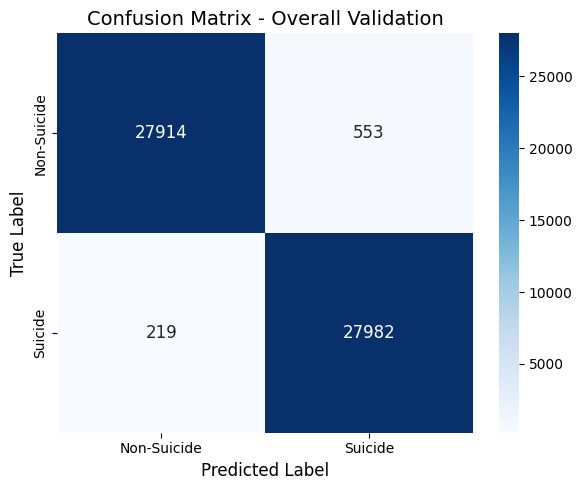

Saved confusion matrix plot to /kaggle/working/confusion_matrix_english_validation.png


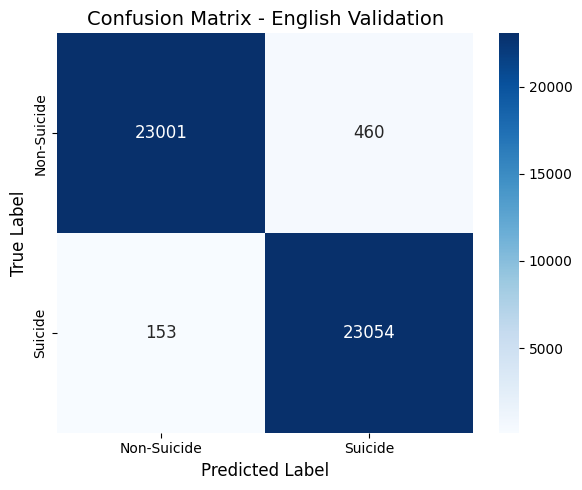

Saved confusion matrix plot to /kaggle/working/confusion_matrix_telugu_validation.png


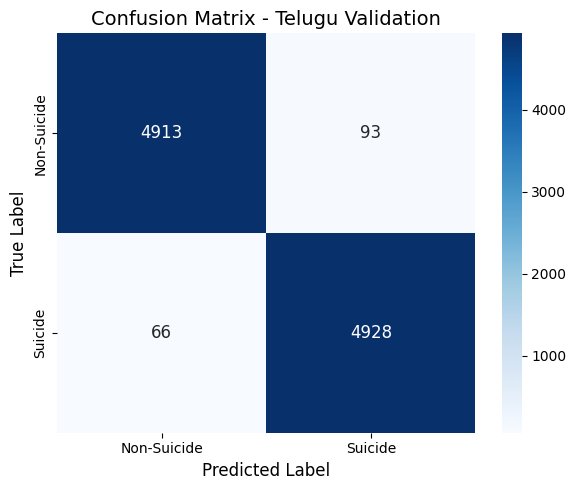


--- Evaluation Script Finished ---
Check console output for metrics and saved plot files in /kaggle/working/ (accessible via Output tab).


In [2]:

# !pip install transformers matplotlib seaborn scikit-learn torch pandas

# --------------------------------------------------------------------------
# Imports
# --------------------------------------------------------------------------
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from torch.cuda.amp import autocast # For consistency if validation used autocast
from collections import OrderedDict
import time

# --------------------------------------------------------------------------
# Configuration - !! UPDATE THESE PATHS !!
# --------------------------------------------------------------------------
# Adjust these paths based on your Kaggle Input directory structure (see Step 4 above)
english_ds_path = "/kaggle/input/english-ds-binary/BinaryCsv_English_dataset_UTF8.csv"
telugu_ds_path = "/kaggle/input/telugu-ds-binary/Binary_telugu_dataset.csv"
model_path = "/kaggle/input/dat_nlp_model/pytorch/default/1/model_epoch_3.pth" # <-- CHANGE 'my-muril-model-epoch3' if your dataset name is different

model_name = "google/muril-base-cased"
max_length = 128
batch_size = 64  # Use the same batch size as validation in training
seed = 42 # Ensure same split as training script used (via torch.manual_seed)

# --------------------------------------------------------------------------
# Setup
# --------------------------------------------------------------------------
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

# --------------------------------------------------------------------------
# Data Loading and Splitting (Mirroring training script)
# --------------------------------------------------------------------------
print("\nLoading datasets...")
try:
    start_time = time.time()
    english_df = pd.read_csv(english_ds_path, encoding='utf-8')
    telugu_df = pd.read_csv(telugu_ds_path, encoding='utf-8')
    print(f"Datasets loaded in {time.time() - start_time:.2f} seconds.")
except FileNotFoundError as e:
    print(f"Error: Could not find dataset file: {e}")
    print(f"Please double-check the 'english_ds_path' and 'telugu_ds_path' variables.")
    # Stop execution if files not found in Kaggle
    raise e # Re-raise the exception to stop the cell

# Add domain labels
english_df['domain'] = 0
telugu_df['domain'] = 1

# Combine datasets
full_df = pd.concat([english_df, telugu_df])

# Split into train and validation sets - USE THE SAME PARAMETERS
# Using random_state=seed ensures the split is the same as the training script
print("Splitting data into training and validation sets (to recreate val_df)...")
_, val_df = train_test_split(
    full_df,
    test_size=0.2,
    stratify=full_df[['class', 'domain']],
    random_state=seed
)

print(f"Validation set size: {len(val_df)}")
print("Validation set class distribution:\n", val_df['class'].value_counts(normalize=True))
print("\nValidation set domain distribution:\n", val_df['domain'].value_counts(normalize=True))

# --------------------------------------------------------------------------
# Model and Dataset Definitions (Copied from training script)
# --------------------------------------------------------------------------

# Custom Dataset class
class SuicideDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        # Ensure text column is string type, handle potential NaN values
        self.texts = dataframe['text'].astype(str).fillna('fillna').tolist()
        self.labels = dataframe['class'].tolist()
        self.domains = dataframe['domain'].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx] # Already pre-processed in __init__
        label = self.labels[idx]
        domain = self.domains[idx]
        try:
            encoding = self.tokenizer(
                text, return_tensors='pt', max_length=self.max_length,
                truncation=True, padding='max_length'
            )
            return {
                'input_ids': encoding['input_ids'].squeeze(), # Use squeeze(0) instead of squeeze()
                'attention_mask': encoding['attention_mask'].squeeze(), # Use squeeze(0)
                'labels': torch.tensor(label, dtype=torch.long),
                'domains': torch.tensor(domain, dtype=torch.long)
            }
        except Exception as e:
            print(f"Error tokenizing text at index {idx}: {text}")
            print(f"Error: {e}")
            # Return a dummy item or raise error - returning dummy might skew results
            # For now, let's raise it to be aware
            raise e


# Gradient Reversal Layer
class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

# DAT Model
class DATModel(nn.Module):
    def __init__(self, base_model, hidden_size=768, num_classes=2, num_domains=2):
        super(DATModel, self).__init__()
        self.base_model = base_model
        self.task_classifier = nn.Linear(hidden_size, num_classes)
        self.domain_classifier = nn.Linear(hidden_size, num_domains)
        self.dropout = nn.Dropout(0.1) # From training script

    def forward(self, input_ids, attention_mask, lambda_=1.0):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        features = outputs.last_hidden_state[:, 0, :] # CLS token
        features = self.dropout(features)
        task_logits = self.task_classifier(features)
        # Apply GRL for domain logits only if calculating domain loss during eval
        domain_features = GradientReversal.apply(features, lambda_) # For eval, lambda_ often 0 or GRL ignored
        domain_logits = self.domain_classifier(domain_features)
        return task_logits, domain_logits

# --------------------------------------------------------------------------
# Load Tokenizer, Model, and State Dict
# --------------------------------------------------------------------------
print("\nLoading tokenizer and base model...")
start_time = time.time()
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)
print(f"Tokenizer and base model loaded in {time.time() - start_time:.2f} seconds.")

print("Instantiating DATModel...")
model = DATModel(base_model) # Instantiate model first
model.to(device) # Move model skeleton to device

print(f"Loading saved state dict from: {model_path}")
start_time = time.time()
try:
    # Load the state dict onto the CPU first to avoid GPU memory spikes if the model is large
    state_dict = torch.load(model_path, map_location='cpu')

    # Handle potential DataParallel prefix ('module.')
    new_state_dict = OrderedDict()
    is_data_parallel = any(k.startswith('module.') for k in state_dict.keys())

    for k, v in state_dict.items():
        name = k[7:] if is_data_parallel else k # remove 'module.' prefix if present
        new_state_dict[name] = v

    model.load_state_dict(new_state_dict)
    print(f"Model state dict loaded successfully in {time.time() - start_time:.2f} seconds.")
    if is_data_parallel:
        print("Detected state dict was saved using nn.DataParallel.")

except FileNotFoundError:
    print(f"Error: Model checkpoint '{model_path}' not found.")
    print("Please ensure the 'model_path' variable points to the correct file in /kaggle/input/...")
    raise # Stop execution
except Exception as e:
    print(f"Error loading model state_dict: {e}")
    raise # Stop execution


# Set model to evaluation mode *after* loading weights
model.eval()
print("Model is in evaluation mode.")

# --------------------------------------------------------------------------
# Evaluation Function
# --------------------------------------------------------------------------
def evaluate_model(model, dataloader, device, description="Evaluation"):
    """Runs inference and collects predictions and labels."""
    model.eval() # Ensure model is in eval mode
    all_labels = []
    all_preds = []
    all_domains_actual = [] # Store actual domains from data

    total_task_loss = 0.0
    total_domain_loss = 0.0
    criterion_task = nn.CrossEntropyLoss()
    criterion_domain = nn.CrossEntropyLoss()

    print(f"\nStarting {description}...")
    start_time = time.time()
    with torch.no_grad(): # Disable gradient calculation
        for batch_idx, batch in enumerate(dataloader):
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)
            domains = batch['domains'].to(device, non_blocking=True) # Actual domains

            # Use autocast for potential speedup if GPU supports it and model benefits
            with autocast(enabled=torch.cuda.is_available()):
                # Get both task and domain logits from the model
                task_logits, domain_logits = model(input_ids, attention_mask)

                # Calculate losses (optional for eval, but good for sanity check)
                loss_task = criterion_task(task_logits, labels)
                loss_domain = criterion_domain(domain_logits, domains) # Compare predicted domain vs actual

            total_task_loss += loss_task.item()
            total_domain_loss += loss_domain.item()

            # Get task predictions (main goal)
            predictions = torch.argmax(task_logits, dim=1)

            # Append batch results (move to CPU before converting to numpy)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predictions.cpu().numpy())
            all_domains_actual.extend(domains.cpu().numpy())

            if (batch_idx + 1) % 50 == 0: # Print progress every 50 batches
                 print(f"  Processed batch {batch_idx+1}/{len(dataloader)}")


    end_time = time.time()
    avg_task_loss = total_task_loss / len(dataloader) if len(dataloader) > 0 else 0
    avg_domain_loss = total_domain_loss / len(dataloader) if len(dataloader) > 0 else 0

    print(f"{description} finished in {end_time - start_time:.2f} seconds.")
    print(f"  Average Task Loss: {avg_task_loss:.4f}")
    print(f"  Average Domain Loss: {avg_domain_loss:.4f}") # How well it predicts domain (lower is better if GRL worked)

    return np.array(all_labels), np.array(all_preds), np.array(all_domains_actual)

# --------------------------------------------------------------------------
# Prepare DataLoaders for Evaluation
# --------------------------------------------------------------------------
print("\nCreating DataLoaders for validation subsets...")

# Overall Validation Set
val_dataset = SuicideDataset(val_df, tokenizer, max_length=max_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True) # num_workers > 0 if using GPU

# English-only Validation Set
english_val_df = val_df[val_df['domain'] == 0].copy() # Use .copy() to avoid SettingWithCopyWarning
english_val_dataset = SuicideDataset(english_val_df, tokenizer, max_length=max_length)
english_val_loader = DataLoader(english_val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Telugu-only Validation Set
telugu_val_df = val_df[val_df['domain'] == 1].copy() # Use .copy()
telugu_val_dataset = SuicideDataset(telugu_val_df, tokenizer, max_length=max_length)
telugu_val_loader = DataLoader(telugu_val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("DataLoaders created.")

# --------------------------------------------------------------------------
# Run Evaluation
# --------------------------------------------------------------------------
# Overall
overall_labels, overall_preds, _ = evaluate_model(model, val_loader, device, "Overall Validation")

# English
if len(english_val_loader) > 0:
    eng_labels, eng_preds, _ = evaluate_model(model, english_val_loader, device, "English Validation")
else:
    print("\nSkipping English evaluation - No English samples in validation set.")
    eng_labels, eng_preds = np.array([]), np.array([])

# Telugu
if len(telugu_val_loader) > 0:
    tel_labels, tel_preds, _ = evaluate_model(model, telugu_val_loader, device, "Telugu Validation")
else:
    print("\nSkipping Telugu evaluation - No Telugu samples in validation set.")
    tel_labels, tel_preds = np.array([]), np.array([])


# --------------------------------------------------------------------------
# Calculate and Print Metrics
# --------------------------------------------------------------------------
def calculate_and_print_metrics(labels, preds, title):
    if len(labels) == 0:
        print(f"\n--- Metrics for {title} ---")
        print("No samples to evaluate.")
        print("-" * (len(title) + 16))
        return None # Return None if no data

    accuracy = accuracy_score(labels, preds)
    # Calculate weighted metrics to account for potential class imbalance
    precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    # Calculate macro metrics to average unweighted per-class scores
    precision_m, recall_m, f1_m, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    # Calculate per-class metrics
    precision_pc, recall_pc, f1_pc, support_pc = precision_recall_fscore_support(labels, preds, average=None, zero_division=0)


    print(f"\n--- Metrics for {title} ---")
    print(f"Total Samples: {len(labels)}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision_w:.4f} | Macro Precision: {precision_m:.4f}")
    print(f"Weighted Recall: {recall_w:.4f}    | Macro Recall: {recall_m:.4f}")
    print(f"Weighted F1-Score: {f1_w:.4f}   | Macro F1-Score: {f1_m:.4f}")

    print("\nClassification Report:")
    # Define target names based on your classes (assuming 0: non-suicide, 1: suicide)
    target_names = ['class 0 (non-suicide)', 'class 1 (suicide)']
    try:
        print(classification_report(labels, preds, target_names=target_names, zero_division=0))
    except ValueError as e:
         print(f"Could not generate classification report: {e}")
         print("This might happen if only one class is present in the predictions or labels.")

    print("-" * (len(title) + 16)) # Separator line

    # Return confusion matrix only if evaluation was possible
    return confusion_matrix(labels, preds)

# Calculate metrics for each subset
cm_overall = calculate_and_print_metrics(overall_labels, overall_preds, "Overall Validation")
cm_eng = calculate_and_print_metrics(eng_labels, eng_preds, "English Validation")
cm_tel = calculate_and_print_metrics(tel_labels, tel_preds, "Telugu Validation")


# --------------------------------------------------------------------------
# Visualize Confusion Matrices
# --------------------------------------------------------------------------
def plot_confusion_matrix(cm, title, labels=['Non-Suicide', 'Suicide']):
    if cm is None: # Check if CM calculation was skipped
        print(f"Skipping confusion matrix plot for {title} (no data).")
        return

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels,
                annot_kws={"size": 12}) # Increase annotation font size
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.title(f'Confusion Matrix - {title}', fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save the plot to Kaggle's output directory
    # Output directory in Kaggle is /kaggle/working/
    filename = f"/kaggle/working/confusion_matrix_{title.lower().replace(' ', '_')}.png"
    try:
        plt.savefig(filename)
        print(f"Saved confusion matrix plot to {filename}")
    except Exception as e:
        print(f"Error saving plot {filename}: {e}")
    plt.show() # Display the plot in the notebook output

print("\nGenerating Confusion Matrix plots...")
plot_confusion_matrix(cm_overall, "Overall Validation")
plot_confusion_matrix(cm_eng, "English Validation")
plot_confusion_matrix(cm_tel, "Telugu Validation")

print("\n--- Evaluation Script Finished ---")
print("Check console output for metrics and saved plot files in /kaggle/working/ (accessible via Output tab).")